In [1]:
import multiprocessing as mp
from SALib.sample import saltelli
import pandas as pd
import matplotlib.pyplot as plt
import pysd
import scipy as sp
import math
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze
from SALib.analyze import sobol
import warnings
import numpy as np

## Load in model and data

In [2]:
model = pysd.read_vensim('/Users/joey_/Library/CloudStorage/GoogleDrive-joeylitecia@gmail.com/My Drive/School/Msc IS/Year.2/Thesis_project/Final_SFD_final_Jun22.mdl')
data = pd.read_csv('/Users/joey_/Library/CloudStorage/GoogleDrive-joeylitecia@gmail.com/My Drive/School/Msc IS/Year.2/Thesis_project/DataNLEng.csv', delimiter =";")


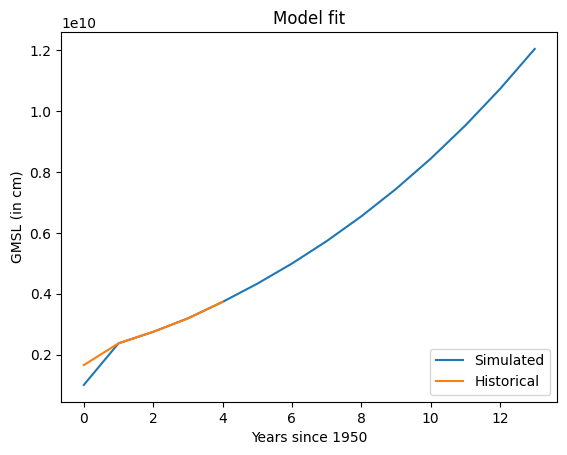

In [6]:
# Plot model after initial simulation and inspect data
default = model.run()
plt.plot(default.index, (default['Total Energy Use of data Center']), label='Simulated')
plt.plot(data.index, data["EnergyKw"], label='Historical')
plt.xlabel('Years since 1950')
plt.ylabel('GMSL (in cm)')
plt.title('Model fit')
plt.legend(loc='lower right')


## Data Transformation

### Transform dataset to be useful for simulation
The transformation involves creating a subset of the dataset starting in 1950 instead of 1880 and changing the timestep from month to year (since the timestep for the simulation model is also year)

In [4]:
df = data[['EnergyKw']]


display(df)

,EnergyKw
0,1652000000
1,2367000000
2,2747000000
3,3184000000
4,3730000000


## Calibration

In [7]:
print(default.columns)

Index(['FINAL TIME', 'INITIAL TIME', 'SAVEPER', 'TIME STEP',
       'Network Traffic Capacity', 'Bandwidth', 'Carbon Intensity',
       'Number of routers', 'CI initial val', 'Routers per Server',
       'Max Power', 'Min Power', 'Total IT power consumption',
       'CO2 Emissionss', 'Total Energy Use of data Center', 'outflow CI',
       'Outflow CO2', 'TIPC initial val', 'Number of Cores',
       'Server Power Consumption', 'Additional Functionalities and Services',
       'AFS Coefficient', 'Outflow TEUDC',
       '"User Needs for Data-Intensive Services"', 'Power Usage Effectiveness',
       'Outflow IT', 'Network Power Consumption', 'Carbon Intensity Rate',
       'MinP alpha', 'MinP b1', 'MinP b2', 'MaxP b2', 'MaxP b1', 'MaxP alpha',
       'AW Coefficient', 'NTL coefficient', 'Energy Coefficient', 'UCS b1',
       'Usage of Cloud Services', 'Application Workload',
       'Average Processor Speed', 'Average Rated Power Supply of Servers',
       'TEUDC initial val', 'UCS initial 

In [13]:
def error(param_list: list) -> int:
    '''
    Takes the model parameters that we intend to vary
    Returns sum of squared error between the model's prediction and the initial dataset
    '''
    
    # Unpack the parameter list
    AW_Coefficient, Energy_Coefficient, UCS_b1, Power_Usage_Effectiveness, TEUDC_initial_val, UCS_initial_val, UDS_Coefficient, Utilization_Rate, Server_Units, TIPC_initial_val = param_list
    
    # Run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'AW Coefficient': AW_Coefficient,
                               'Energy Coefficient': Energy_Coefficient,
                               'UCS b1': UCS_b1,
                               'Power Usage Effectiveness': Power_Usage_Effectiveness,
                               'TEUDC initial val': TEUDC_initial_val,
                               'UCS initial val': UCS_initial_val,
                               'UDS Coefficient': UDS_Coefficient,
                               'Utilization Rate': Utilization_Rate,
                               'Server Units': Server_Units,
                               'TIPC initial val': TIPC_initial_val
                               
                               },
                       return_columns=['Total Energy Use of data Center'],
                       return_timestamps=list(df.index.values))

    # Return the sum of the squared errors
    return sum((result['Total Energy Use of data Center'] - df["EnergyKw"])**2)


In [14]:
# Suggest a starting point and parameter bounds for the optimizer
AW_Coefficient_guess = 0.7
Energy_Coefficient_guess = 3e-09
UCS_b1_guess = 0.01
Power_Usage_Effectivenesss_guess = 1.58
TEUDC_initial_val_guess = 1000000000
UCS_initial_val_guess = 40
UDS_Coefficient_guess = 0.05
Utilization_Rate_guess = 0.7
Server_Units_guess = 2000
TIPC_initial_val_guess =900000000

AW_Coefficient_bounds = (0.6, 0.8)
Energy_Coefficient_bounds = (3e-10, 0.001)
UCS_b1_bounds = (0.01, 1)
Power_Usage_Effectivenesss_bounds = (1.4, 1.70)
TEUDC_initial_val_bounds = (1, 1.653e+09)
UCS_initial_val_bounds = (1, 90)
UDS_Coefficient_bounds = (0.01, 1)
Utilization_Rate_bounds = (0.1, 0.9)
Server_Units_bounds = (1000, 5000)
TIPC_initial_val_bounds = (1, 1.652e+09)

In [15]:
# Run simulation
result = model.run(params={'AW Coefficient':AW_Coefficient_guess,
                           'Energy Coefficient' :Energy_Coefficient_guess,
                           'UCS b1':UCS_b1_guess,
                           'Power Usage Effectiveness':Power_Usage_Effectivenesss_guess,
                           'TEUDC initial val':TEUDC_initial_val_guess,
                           'UCS initial val':UCS_initial_val_guess,
                           'UDS Coefficient':UDS_Coefficient_guess,
                           'Utilization Rate':Utilization_Rate_guess,
                           'Server Units':Server_Units_guess,
                           'TIPC initial val': TIPC_initial_val_guess

                            },
                    return_columns=['Total Energy Use of data Center'],
                    return_timestamps=list(df.index.values))

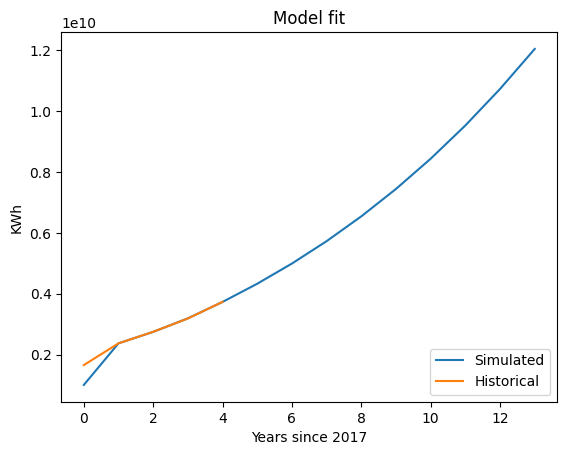

In [16]:
# Plot the simulation
plt.plot(default.index, (default['Total Energy Use of data Center']), label='Simulated')
plt.plot(data.index, data["EnergyKw"], label='Historical')
plt.xlabel('Years since 2017')
plt.ylabel('KWh')
plt.title('Model fit')
plt.legend(loc='lower right')

### Minimize the error with an optimization function 

Pass the error function into the optimization function, along with the initial guess of the parameters we are trying to optimize. 

In [17]:
res = sp.optimize.minimize(error, [AW_Coefficient_guess,
                                    Energy_Coefficient_guess,
                                    UCS_b1_guess,
                                    Power_Usage_Effectivenesss_guess,
                                    TEUDC_initial_val_guess,
                                    UCS_initial_val_guess,
                                    UDS_Coefficient_guess,
                                    Utilization_Rate_guess,
                                    Server_Units_guess,
                                    TIPC_initial_val_guess
                                    ],
                                       method='L-BFGS-B',
                                       bounds=[AW_Coefficient_bounds,
                                    Energy_Coefficient_bounds,
                                    UCS_b1_bounds,
                                    Power_Usage_Effectivenesss_bounds,
                                    TEUDC_initial_val_bounds,
                                    UCS_initial_val_bounds,
                                    UDS_Coefficient_bounds,
                                    Utilization_Rate_bounds,
                                    Server_Units_bounds,
                                    TIPC_initial_val_bounds
                                    ]
                           )
res.x

array([7.03929680e-01, 1.00000000e-03, 2.51411269e-01, 1.51897967e+00,
       1.00000000e+09, 3.14128599e+01, 1.30881328e-01, 6.45830896e-01,
       1.77986567e+03, 9.00000000e+08])

### Result

If we run the simulation with the parameters as suggested by the optimizers we see that the model follows the general behaviour of the data, but is too simple to truly capture the correct shape of the curve.

In [18]:
AW_Coefficient, Energy_Coefficient, UCS_b1, Power_Usage_Effectiveness, TEUDC_initial_val, UCS_initial_val, UDS_Coefficient, Utilization_Rate, Server_Units, TIPC_initial_val = res.x

#run the model with the new parameters, returning the info we're interested in
result = model.run(params={'AW Coefficient': AW_Coefficient,
                               'Energy Coefficient': Energy_Coefficient,
                               'UCS b1': UCS_b1,
                               'Power Usage Effectiveness': Power_Usage_Effectiveness,
                               'TEUDC initial val': TEUDC_initial_val,
                               'UCS initial val': UCS_initial_val,
                               'UDS Coefficient': UDS_Coefficient,
                               'Utilization Rate': Utilization_Rate,
                               'Server Units': Server_Units,
                               'TIPC initial val': TIPC_initial_val
                               },
                       return_columns=['Total Energy Use of data Center'],
                       return_timestamps=list(df.index.values))


In [19]:
print(list(res.x))

[0.703929679694682, 0.001, 0.2514112694145701, 1.5189796727887672, 999999999.9998877, 31.412859883771, 0.13088132767058774, 0.6458308962385699, 1779.8656724578957, 899999999.9999976]


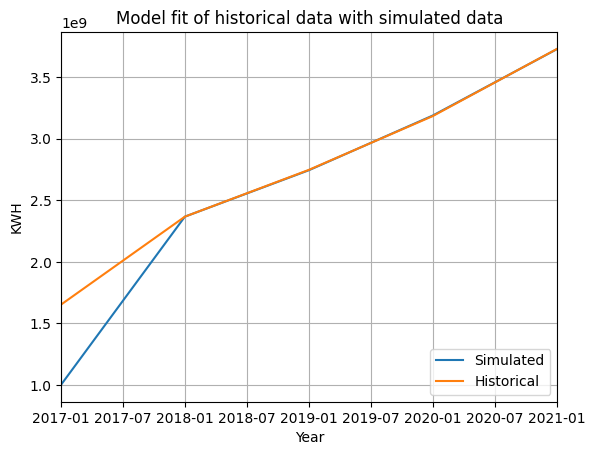

In [20]:
# Plot the simulation
result.index = pd.date_range(start='2016', periods=len(result.index), freq='YE')
data.index = pd.date_range(start='2016', periods=len(data.index), freq='YE')

# Plot the data
plt.plot(result.index, (result['Total Energy Use of data Center']), label='Simulated')
plt.plot(data.index, df, label='Historical')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('KWH')
plt.title('Model fit of historical data with simulated data')

# Set x-axis limits
plt.xlim(pd.Timestamp('2017'), pd.Timestamp('2021'))

# Add grid and legend
plt.grid()
plt.legend(loc='lower right')

### Calibration results

In [21]:
print(list(res.x))
display(result[['Total Energy Use of data Center']])

[0.703929679694682, 0.001, 0.2514112694145701, 1.5189796727887672, 999999999.9998877, 31.412859883771, 0.13088132767058774, 0.6458308962385699, 1779.8656724578957, 899999999.9999976]


,Total Energy Use of data Center
2016-12-31,1.000000e+09
2017-12-31,2.367082e+09
2018-12-31,2.744027e+09
2019-12-31,3.188528e+09
2020-12-31,3.728295e+09


In [22]:
# Calculate squared root error
math.sqrt(res.fun/len(data))/df.max()

EnergyKw    0.078175
dtype: float64

## Sensitivity Analysis

In [26]:
parameter1 = 'AW Coefficient'
parameter2 = 'Energy Coefficient'
parameter3 = 'Carbon Intensity Rate'
parameter4 = 'UCS b1'
parameter5 = 'Power Usage Effectiveness'
parameter6 = 'TEUDC initial val'
parameter7 = 'UCS initial val'
parameter8 = 'UDS Coefficient'
parameter9 = 'Utilization Rate'
parameter10 = 'Server Units'
parameter11 = 'TIPC initial val'

p_list = [parameter1,parameter2, parameter3,parameter4,parameter5,parameter6,parameter7,parameter8,parameter9,parameter10,parameter11]

bounds = [
    (0.6, 0.8),
    (3e-10, 1),
    (0, 1),
    (0.01, 1),
    (1, 3),
    (1, 1.653e+09),
    (30, 90),
    (0.01, 1),
    (0.1, 0.9),
    (1000, 5000),
    (1, 1.652e+09)
]


In [27]:
# define problem for determining the sensitivity indices using SALib
problem = {
    'num_vars': 11,
    'names': p_list,
    
    # Avoid float values by multiplying each value by 10
    'bounds': bounds
}

# Calculate sample points used for sensitivity analysis
param_values = sample(problem, 524288, calc_second_order=False)

In [28]:
#observable is the outcome variable we are optimizing for for this model it is either CO2 Emissionss and Total Energy Use of data Center
observable = 'CO2 Emissionss'

# array for observable values
Y = np.zeros([param_values.shape[0]])

# loop through all parameter combinations in the sample
for i, X in enumerate(param_values):
    param1_val, param2_val, param3_val, param4_val, param5_val, param6_val, param7_val, param8_val, param9_val, param10_val, param11_val = X

    # store observable value at this parameter combination
    # again, we want to ignore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        Y[i] = model.run(params={
    parameter1: param1_val, parameter2: param2_val, parameter3: param3_val, 
    parameter4: param4_val, parameter5: param5_val, parameter6: param6_val,
    parameter7: param7_val, parameter8: param8_val, parameter9: param9_val, 
    parameter10: param10_val, parameter11: param11_val
    },
                         return_timestamps=[13],
                         return_columns=[observable]).loc[13, observable]


In [29]:
# perform calculation of sensitivity indices
Si = analyze(problem, Y, calc_second_order=False, print_to_console=True)

print(Si)

/Users/joey_/Library/Python/3.9/lib/python/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                                 ST   ST_conf
AW Coefficient             0.017669  0.001977
Energy Coefficient         0.373943  0.048965
Carbon Intensity Rate      0.856781  0.061852
UCS b1                     0.342492  0.034903
Power Usage Effectiveness  0.170548  0.017061
TEUDC initial val          0.003149  0.000367
UCS initial val            0.002253  0.000238
UDS Coefficient            0.339240  0.029678
Utilization Rate           0.310795  0.028060
Server Units               0.248047  0.024636
TIPC initial val           0.000681  0.000106
                                 S1   S1_conf
AW Coefficient             0.000063  0.000379
Energy Coefficient         0.010552  0.002231
Carbon Intensity Rate      0.103417  0.013960
UCS b1                     0.008510  0.002210
Power Usage Effectiveness  0.002962  0.001280
TEUDC initial val          0.000064  0.000145
UCS initial val            0.000114  0.000155
UDS Coefficient            0.008643  0.001992
Utilization Rate           0.00665

S1: [6.28822545e-05 1.05522800e-02 1.03416552e-01 8.51047349e-03
 2.96170303e-03 8.64259321e-03 6.65273681e-03 4.33518382e-03]
S1_conf: [0.00037851 0.00223084 0.01396011 0.00221022 0.00127959 0.00199247
 0.00160284 0.00143986]
ST: [0.0176689  0.37394287 0.85678111 0.34249221 0.17054782 0.33924015
 0.3107954  0.24804697]
ST_conf: [0.0019768  0.04896473 0.06185201 0.03490308 0.01706091 0.02967756
 0.02805961 0.02463649]


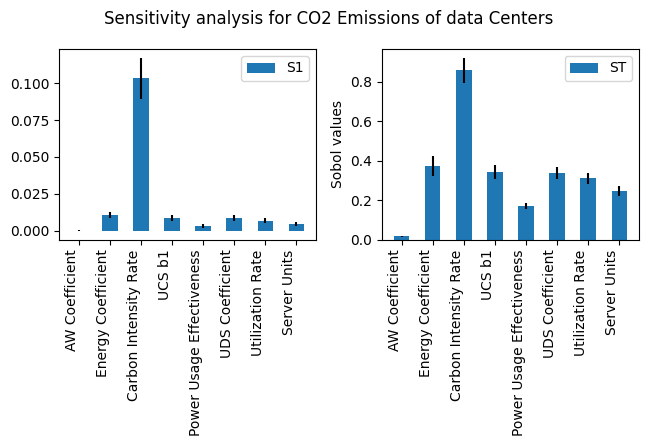

In [59]:
# Exclude parameter6, parameter7, and parameter11 from the results
exclude_indices = [5, 6, 10]
filtered_names = [name for i, name in enumerate(p_list) if i not in exclude_indices]
filtered_Si = {key: np.delete(val, exclude_indices, axis=0) if isinstance(val, np.ndarray) else val for key, val in Si.items()}

# Print filtered results
for key, val in filtered_Si.items():
    print(f"{key}: {val}")

# Plot filtered results with confidence intervals in separate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 4.5))

indices = np.arange(len(filtered_names))
width = 0.5

# Plot S1 with confidence intervals
ax1.bar(indices, filtered_Si['S1'], width, yerr=filtered_Si['S1_conf'], capsize=0, label='S1')
x1.set_xticks(indices)
ax1.set_xticklabels(filtered_names, rotation=90, ha='right')
ax1.legend()

# Plot ST with confidence intervals
ax2.bar(indices, filtered_Si['ST'], width, yerr=filtered_Si['ST_conf'], capsize=0, label='ST')
ax2.set_xticks(indices)
ax2.set_xticklabels(filtered_names, rotation=90, ha='right')
ax2.legend()


plt.gca()
plt.ylabel('Sobol values')
plt.suptitle('Sensitivity analysis for CO2 Emissions of data Centers')
plt.tight_layout()
plt.show()